In [11]:
import numpy as np
from numpy import load, savez_compressed
import pandas as pd
from os import listdir, mkdir
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import fetch_lfw_people #lfw dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.svm import SVC

In [7]:
#load the compressed dataset and facenet keras model
n_components = 150
# pca = PCA(n_components=n_components, whiten=True)
ipca = IncrementalPCA(n_components=n_components, batch_size=16)
dataset_npz_filenames = []
reg_expr = '^lfw-deepfunneled-dataset_[0-9]{4}.npz'
for file in listdir('./'):
    if re.search(reg_expr, file):
        dataset_npz_filenames.append(file)

print(dataset_npz_filenames)

for i, file in enumerate(dataset_npz_filenames):
    data = load(file)
    X_train = data['arr_0']
    X_train = X_train.reshape(X_train.shape[0], -1)
    print(f"i = {i} | Partial fit on X_train of sizes {X_train.shape}")
    ipca.partial_fit(X_train)

['lfw-deepfunneled-dataset_0002.npz', 'lfw-deepfunneled-dataset_0003.npz', 'lfw-deepfunneled-dataset_0000.npz', 'lfw-deepfunneled-dataset_0005.npz', 'lfw-deepfunneled-dataset_0004.npz', 'lfw-deepfunneled-dataset_0001.npz']
i = 0 | Partial fit on X_train of sizes (1737, 76800)
i = 1 | Partial fit on X_train of sizes (1842, 76800)
i = 2 | Partial fit on X_train of sizes (1949, 76800)
i = 3 | Partial fit on X_train of sizes (1245, 76800)
i = 4 | Partial fit on X_train of sizes (2147, 76800)
i = 5 | Partial fit on X_train of sizes (2633, 76800)


In [10]:
X_train_pca = X_test_pca = np.zeros((0, n_components))

for i, file in enumerate(dataset_npz_filenames):
    data = load(file)
    X_train, X_test = data['arr_0'], data['arr_2']
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    X_train_pca = np.vstack((X_train_pca, ipca.transform(X_train)))
    X_test_pca = np.vstack((X_test_pca, ipca.transform(X_test)))

print(f"X_train_pca shape {X_train_pca.shape} | X_test_pca {X_test_pca.shape}")

X_train_pca shape (11553, 150) | X_test_pca (1679, 150)


In [12]:
# save the PCA embeddings into a file 
savez_compressed("lfw-deepfunneled-pca-embeddings-150.npz", X_train_pca, X_test_pca)

In [6]:
eigenfaces = pca.components_.reshape((n_components, lfw_people.images.shape[1], lfw_people.images.shape[2]))

In [7]:
# Train a support vector machine (SVM) classifier
svm_classifier = SVC(kernel='rbf', class_weight='balanced')
svm_classifier.fit(X_train_pca, y_train)


SVC(class_weight='balanced')

In [8]:
# Predict on the test set
y_pred = svm_classifier.predict(X_test_pca)

In [9]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
print(classification_report(y_test, y_pred, target_names=target_names))

[[  8   3   0   2   0   0   0]
 [  0  57   1   1   0   0   1]
 [  0   6  16   5   0   0   0]
 [  0  10   0 136   0   0   0]
 [  0   2   0   3  19   0   1]
 [  0   5   0   2   1   7   0]
 [  0   3   2   2   0   0  29]]
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.62      0.76        13
     Colin Powell       0.66      0.95      0.78        60
  Donald Rumsfeld       0.84      0.59      0.70        27
    George W Bush       0.90      0.93      0.92       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.94      0.81      0.87        36

         accuracy                           0.84       322
        macro avg       0.90      0.73      0.79       322
     weighted avg       0.87      0.84      0.84       322



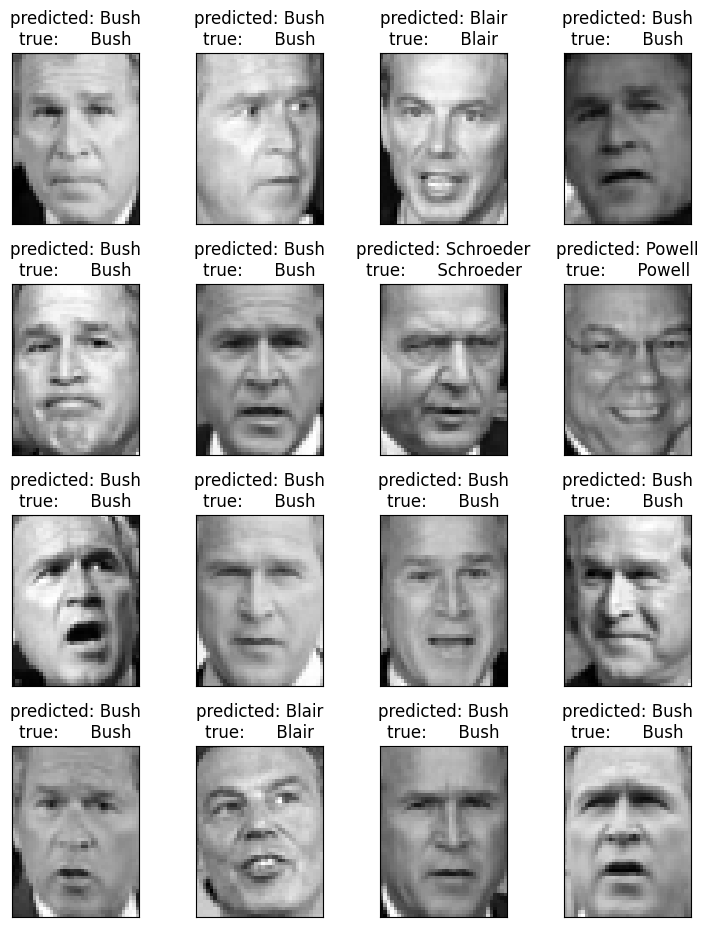

In [10]:
def plot(images, titles, h, w, n_row=4, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((lfw_people.images.shape[1], lfw_people.images.shape[2])), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())



#Plotting the result of the predictions on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot(X_test, prediction_titles, lfw_people.images.shape[1], lfw_people.images.shape[2])

plt.show()

In [11]:
#face details
faces = lfw_people.images
labels = lfw_people.target_names
faceshape = faces[0].shape
print("Face image shape:", faceshape)

Face image shape: (50, 37)


In [12]:
# Create a NxM matrix with N images and M pixels per image for the training set
facematrix_train = np.array([face.flatten() for face in X_train])

In [13]:
pca = PCA(n_components=50).fit(facematrix_train)
eigenfaces = pca.components_

# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of training samples
weights_train = eigenfaces @ (facematrix_train - pca.mean_).T
print("Shape of the training weight matrix:", weights_train.shape)

Shape of the training weight matrix: (50, 966)


Showing the eigenfaces


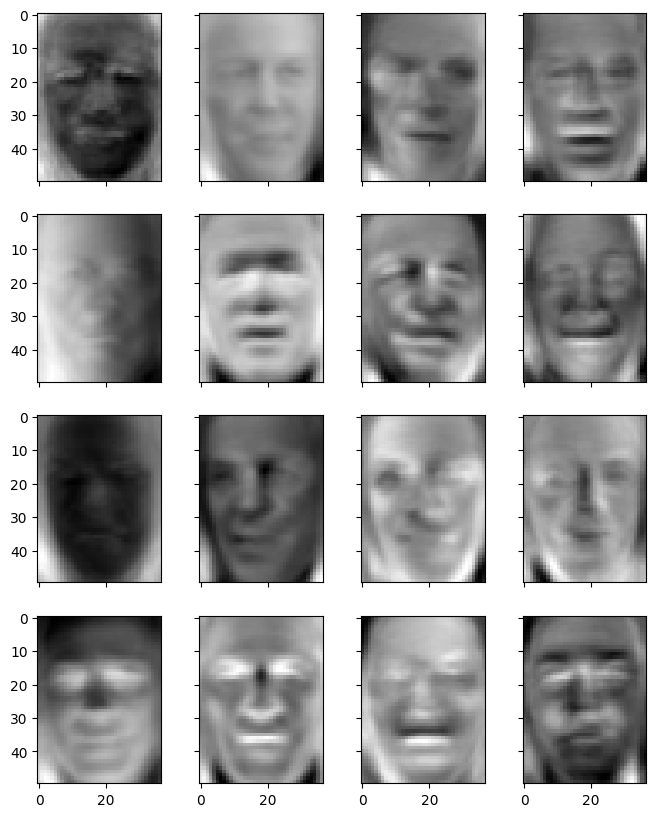

In [14]:
# Show the first 16 eigenfaces
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
for i in range(16):
    axes[i % 4][i // 4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the eigenfaces")
plt.show()

In [15]:
# # Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
# weights = eigenfaces @ (facematrix - pca.mean_).T
# print("Shape of the weight matrix:", weights.shape)


Test Image 31 - True Label: Donald Rumsfeld
Best match: George W Bush with Euclidean distance: 9.348931


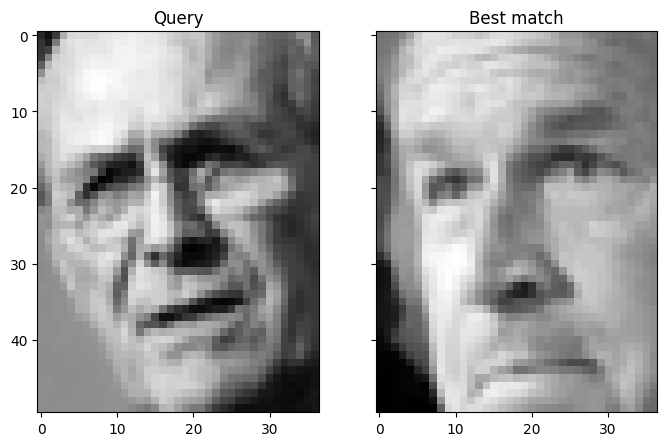


Test Image 32 - True Label: George W Bush
Best match: Ariel Sharon with Euclidean distance: 10.520082


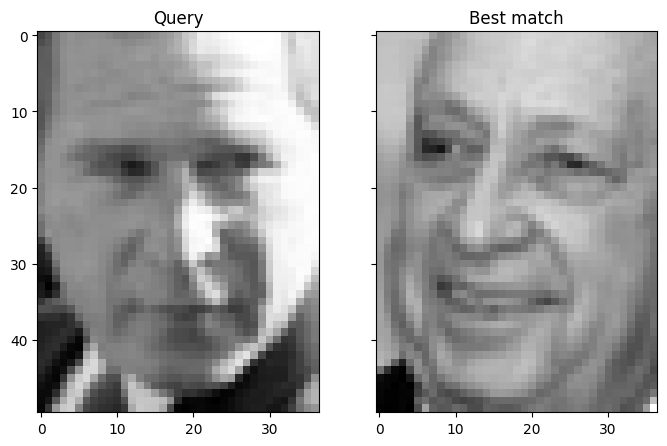


Test Image 33 - True Label: George W Bush
Best match: George W Bush with Euclidean distance: 9.333598


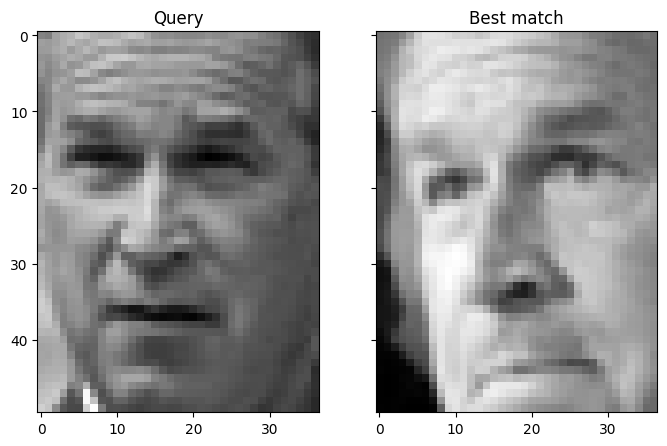


Test Image 34 - True Label: George W Bush
Best match: Tony Blair with Euclidean distance: 9.854728


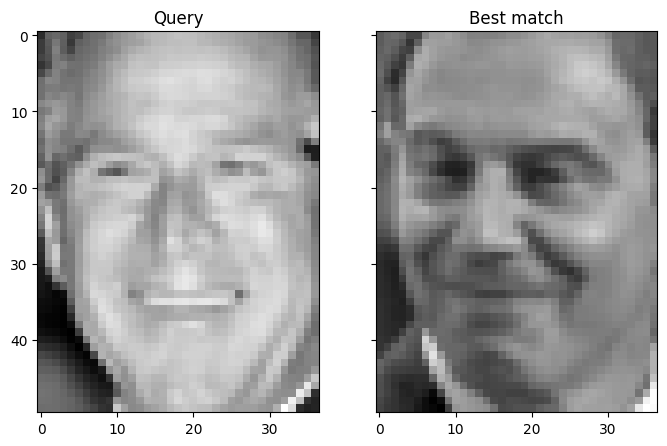


Test Image 35 - True Label: George W Bush
Best match: George W Bush with Euclidean distance: 9.351536


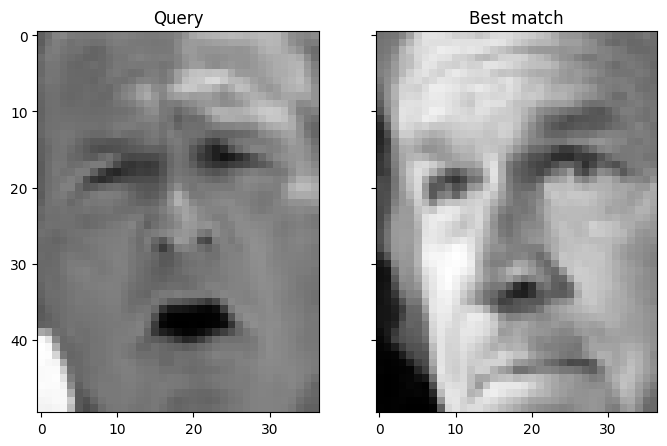

In [22]:
# Test on out-of-sample images from the test set
for i in range(30,35):  # Selecting 3 images for demonstration
    query = X_test[i].reshape(1, -1)
    query_weight = eigenfaces @ (query.flatten() - pca.mean_).reshape(-1, 1)
    euclidean_distance = np.linalg.norm(weights_train - query_weight, axis=1)
    best_match = np.argmin(euclidean_distance)
    print(f"\nTest Image {i + 1} - True Label: {labels[y_test[i]]}")
    print("Best match:", labels[y_train[best_match]], "with Euclidean distance:", euclidean_distance[best_match])

    # Visualize
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
    axes[0].imshow(query.reshape(faceshape), cmap="gray")
    axes[0].set_title("Query")
    axes[1].imshow(facematrix_train[best_match].reshape(faceshape), cmap="gray")
    axes[1].set_title("Best match")
    plt.show()

In [21]:
# Test on out-of-sample image of existing class
# query = X_test[i].reshape(1, -1)
# query_weight = eigenfaces @ (query.flatten() - pca.mean_).reshape(-1, 1)
# euclidean_distance = np.linalg.norm(weights_train - query_weight, axis=1)
# best_match = np.argmin(euclidean_distance)

query = faces[np.where(lfw_people.target == 6)][0].reshape(1, -1)  # Change class index as needed
query_weight = eigenfaces @ (query.flatten() - pca.mean_).reshape(-1,1)
euclidean_distance = np.linalg.norm(weights_train - query_weight, axis=1)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (labels[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix_train[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

IndexError: ignored

In [ ]:
lfw_people.target

In [ ]:
faces

In [ ]:
X_test